# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification. 

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                         transforms.RandomHorizontalFlip(0.5),
                                         transforms.RandomCrop(32, padding=4,padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
transforms_cifar10_test = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

BATCH_SIZE = 128

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle=True, num_workers=2)

#  Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10_test)
testloader = torch.utils.data.DataLoader(testset, batch_size= BATCH_SIZE, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:01<00:00, 89534870.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 frog  deer plane  bird  ship   dog   car  ship   cat   car  frog   car   car  frog horse   cat   cat plane   dog  deer plane  bird  bird plane  deer plane  ship  ship horse  ship  deer  frog  ship plane plane  bird horse horse  frog   dog   dog horse   cat  frog   car   car   car   dog   cat   cat horse truck plane horse   car  frog  ship   dog  frog   dog truck truck  ship   car horse horse plane  ship  deer plane  deer   dog  deer   cat  bird   car   cat plane  deer horse horse   cat horse  ship   car  bird horse   car  deer   cat  frog  deer plane horse   cat truck  frog truck   dog   car plane  ship   dog horse plane truck   cat   car   car plane  frog  frog  frog  frog  bird truck   cat plane   dog   car  frog truck horse horse  deer  ship truck  frog


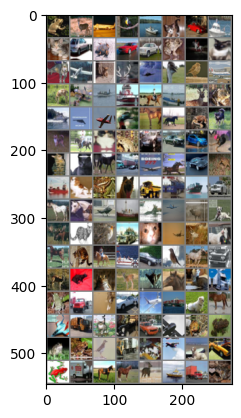

In [ ]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# VGG Model

cfg = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], 
       'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']}

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self.make_layers(cfg['VGG16'])
        self.classifier = nn.Sequential(nn.Linear(512, 10))
        self.initialize_weights()
    
    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU()
                           ]
                in_channels = x
        return nn.Sequential(*layers)

    #He initialization
    def initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight.data)
          m.bias.data.fill_(0)
        elif isinstance(m, nn.Linear):
          nn.init.kaiming_normal_(m.weight.data)
          m.bias.data.fill_(0)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

net = VGG().to(device)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# Loss function and optimizer
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=150, T_mult=1, eta_min=0.0001, last_epoch= -1, verbose=False)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
# Train the model
epochs = 150  # number of epochs

for epoch in range(epochs):

    net.train()

    loss_tmp = 0.0
    epoch_loss = 0.0
    
    for i, data in enumerate(trainloader, start=0):

        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = loss_fun(outputs, labels)

        # Optimize the network 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1] Loss: 1.453
[Epoch - 2] Loss: 0.938
[Epoch - 3] Loss: 0.737
[Epoch - 4] Loss: 0.630
[Epoch - 5] Loss: 0.557
[Epoch - 6] Loss: 0.492
[Epoch - 7] Loss: 0.444
[Epoch - 8] Loss: 0.410
[Epoch - 9] Loss: 0.378
[Epoch - 10] Loss: 0.339
[Epoch - 11] Loss: 0.318
[Epoch - 12] Loss: 0.292
[Epoch - 13] Loss: 0.279
[Epoch - 14] Loss: 0.263
[Epoch - 15] Loss: 0.242
[Epoch - 16] Loss: 0.223
[Epoch - 17] Loss: 0.214
[Epoch - 18] Loss: 0.202
[Epoch - 19] Loss: 0.184
[Epoch - 20] Loss: 0.171
[Epoch - 21] Loss: 0.164
[Epoch - 22] Loss: 0.155
[Epoch - 23] Loss: 0.142
[Epoch - 24] Loss: 0.134
[Epoch - 25] Loss: 0.130
[Epoch - 26] Loss: 0.124
[Epoch - 27] Loss: 0.112
[Epoch - 28] Loss: 0.109
[Epoch - 29] Loss: 0.102
[Epoch - 30] Loss: 0.098
[Epoch - 31] Loss: 0.094
[Epoch - 32] Loss: 0.091
[Epoch - 33] Loss: 0.084
[Epoch - 34] Loss: 0.077
[Epoch - 35] Loss: 0.075
[Epoch - 36] Loss: 0.074
[Epoch - 37] Loss: 0.067
[Epoch - 38] Loss: 0.065
[Epoch - 39] Loss: 0.061
[Epoch - 40] Loss: 0.060
[Epoch - 

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network. 

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat
Predicted:    cat  ship   car plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog tr

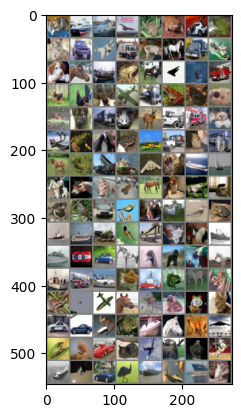

In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(BATCH_SIZE)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(BATCH_SIZE)))

In [ ]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)
    
    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))

## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 11 %

Accuracy of the network on the 10,000 test images: 93 %
